## Dataset, dependencies loading some functions

In [ ]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision import models

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

import time

In [ ]:
# load pretrained models
load_pretrained_models = True
# number of epochs of training
n_epochs = 15
# size of the batches
batch_size = 16
# name of the dataset
dataset_name = "data/SOCOFing/Real"
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of first order momentum of gradient
b2 = 0.999
# number of cpu threads to use during batch generation
n_cpu = 4
# dimensionality of the latent space
latent_dim = 100
# size of each image dimension
img_size = 128
# size of random mask
mask_size = 64
# number of image channels
channels = 1
# interval between image sampling
sample_interval = 150

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

# Calculate output dims of image discriminator (PatchGAN)
patch_h, patch_w = int(mask_size / 2 ** 3), int(mask_size / 2 ** 3)
patch = (1, patch_h, patch_w)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
Tensor

torch.FloatTensor

In [ ]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("drive/MyDrive/maga/fingerprints/archive.zip", 'r') as zObject:

    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall(
        path="data/")

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, img_size=128, mask_size=64, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = sorted(glob.glob("%s/*.BMP" % root))
        self.files = self.files[:-4000] if mode == "train" else self.files[-4000:]

    def apply_random_mask(self, img):
        """Randomly masks image"""
        y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
        y2, x2 = y1 + self.mask_size, x1 + self.mask_size
        masked_part = img[:, y1:y2, x1:x2]
        masked_img = img.clone()
        masked_img[:, y1:y2, x1:x2] = 1

        return masked_img, masked_part

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        i = (self.img_size - self.mask_size) // 2

        masked_part = img[:, i : i + self.mask_size, i : i + self.mask_size]
        masked_img = img.clone()
        masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1

        return masked_img, i # поставив щоб ретурнило саме так для save sample функції, якщо використовувати для валідації то треба щоб було masked_img, masked_part

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        # print(index % len(self.files))
        # try:
        img = self.transform(img)
        # except e:
        # print("img transform")

        if self.mode == "train":
            # For training data perform random mask
            masked_img, aux = self.apply_random_mask(img)
        else:
            # For test data mask the center of the image
            masked_img, aux = self.apply_center_mask(img)

        return img, masked_img, aux

    def __len__(self):
        return len(self.files)

In [ ]:
class ImageDataset_Validation(Dataset):
    def __init__(self, root, transforms_=None, img_size=128, mask_size=64, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = sorted(glob.glob("%s/*.BMP" % root))
        self.files = self.files[:-4000] if mode == "train" else self.files[-4000:]

    def apply_random_mask(self, img):
        """Randomly masks image"""
        y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
        y2, x2 = y1 + self.mask_size, x1 + self.mask_size
        masked_part = img[:, y1:y2, x1:x2]
        masked_img = img.clone()
        masked_img[:, y1:y2, x1:x2] = 1

        return masked_img, masked_part

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        i = (self.img_size - self.mask_size) // 2

        masked_part = img[:, i : i + self.mask_size, i : i + self.mask_size]
        masked_img = img.clone()
        masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1

        return masked_img, masked_part

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        # print(index % len(self.files))
        # try:
        img = self.transform(img)
        # except e:
        # print("img transform")

        if self.mode == "train":
            # For training data perform random mask
            masked_img, aux = self.apply_random_mask(img)
        else:
            # For test data mask the center of the image
            masked_img, aux = self.apply_center_mask(img)

        return img, masked_img, aux

    def __len__(self):
        return len(self.files)

In [ ]:
transforms_ = [
    # transforms.Resize((img_size, img_size), Image.BICUBIC),
    transforms.Grayscale(num_output_channels=1), # it is important to put grayscale before to tensor
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),

    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
dataloader = DataLoader(
    ImageDataset(dataset_name, transforms_=transforms_, img_size=img_size,mask_size=mask_size),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)
test_dataloader = DataLoader(
    ImageDataset(dataset_name, transforms_=transforms_, mode="val", img_size=img_size,mask_size=mask_size),
    batch_size=12,
    shuffle=True,
    num_workers=1,
)



In [ ]:
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    if cuda:
        npimg = img.cpu().numpy()
    else:
        npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Original images


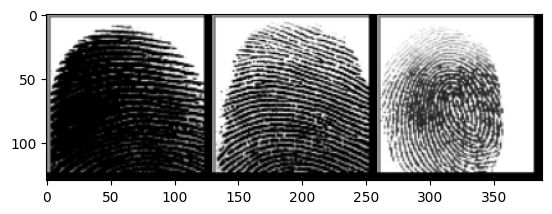

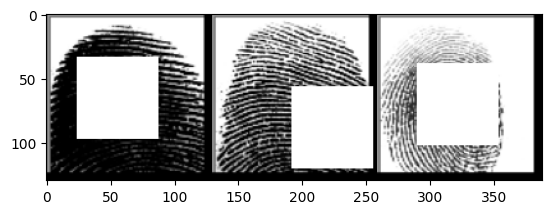

In [ ]:
for i in range(1):
    images, labels, aux = next(iter(dataloader))
    # First visualise the original images
    print('Original images')
    show_image(torchvision.utils.make_grid(images[1:4],3,1))
    plt.show()
    show_image(torchvision.utils.make_grid(labels[1:4],3,1))
    plt.show()
    # show_image(torchvision.utils.make_grid(aux[1:4],3,1))
    # plt.show()

In [ ]:
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        def downsample(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def upsample(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            *downsample(channels, 64, normalize=False),
            *downsample(64, 64),
            *downsample(64, 128),
            *downsample(128, 256),
            *downsample(256, 512),
            nn.Conv2d(512, 4000, 1),
            *upsample(4000, 512),
            *upsample(512, 256),
            *upsample(256, 128),
            *upsample(128, 64),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize in [(64, 2, False), (128, 2, True), (256, 2, True), (512, 1, True)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def save_sample(batches_done, generator):
    samples, masked_samples, i = next(iter(test_dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    i = i[0].item()  # Upper-left coordinate of mask
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, i : i + mask_size, i : i + mask_size] = gen_mask
    # Save sample
    sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    save_image(sample, "images/%d.png" % batches_done, nrow=6, normalize=True)

In [ ]:
# Loss function
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Initialize generator and discriminator
generator = Generator(channels=channels)
discriminator = Discriminator(channels=channels)

In [ ]:
print(generator)

Generator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(512, 4000, kernel_si

In [ ]:
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


In [ ]:
sum(p.numel() for p in generator.parameters())

40397985

In [ ]:
load_pretrained_models = False
# Load pretrained models
if load_pretrained_models:
    if cuda:
        generator.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/generator_perc_3.pth"))
        discriminator.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/discriminator_perc_3.pth"))
    else:
        generator.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/generator_perc_3.pth", map_location=torch.device('cpu')).state_dict())
        discriminator.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/discriminator_perc_3.pth", map_location=torch.device('cpu')).state_dict())
    print("Using pre-trained Context-Encoder GAN model!")

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

if not load_pretrained_models:
    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))


Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def calculate_psnr_ssim(gen_parts, masked_parts):
    # print(f"shapes: {gen_parts.shape}")

    # gen_parts_reshaped = gen_parts.view(-1, 64, 64, 16)
    # masked_parts_reshaped = masked_parts.view(-1, 64, 64)

    gen_parts_transposed = np.squeeze(gen_parts).transpose(1, 2, 0)
    masked_parts_transposed = np.squeeze(masked_parts).transpose(1, 2, 0)

    # print(f"shapes reshaped: {gen_parts_transposed.shape}, {masked_parts_transposed.shape}")

    psnr = peak_signal_noise_ratio(gen_parts_transposed, masked_parts_transposed)
    ssim = structural_similarity(gen_parts_transposed, masked_parts_transposed, multichannel=False)
    return psnr, ssim


def perceptual_loss(img_generated, img_true, vgg_model):
    vgg_model.eval()

    img_generated = img_generated.repeat(1, 3, 1, 1)
    img_true = img_true.repeat(1, 3, 1, 1)


    loss_block1 = vgg_model[:5]
    loss_block2 = vgg_model[:10]
    loss_block3 = vgg_model[:17]

    img_true_block1 = loss_block1(img_true)
    img_generated_block1 = loss_block1(img_generated)
    img_true_block2 = loss_block2(img_true)
    img_generated_block2 = loss_block2(img_generated)
    img_true_block3 = loss_block3(img_true)
    img_generated_block3 = loss_block3(img_generated)

    return torch.mean(torch.square(img_true_block1 - img_generated_block1)) + 2 * torch.mean(torch.square(img_true_block2 - img_generated_block2)) + 5 * torch.mean(torch.square(img_true_block3 - img_generated_block3))

# Set weight for perceptual loss term
lambda_perceptual = 0.10

In [ ]:
vgg_model_ploss = models.vgg16(pretrained=True).features
if cuda:
    vgg_model_ploss.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 138MB/s]


In [ ]:
# n_epochs=3
# perc_loss = True
# gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []

# percept_losses = []
# combined_losses = []

# for epoch in range(n_epochs):

#     ### Training ###
#     gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0

#     gen_percept_loss, gen_combined_loss, gen_psnr, gen_ssim = 0, 0, 0, 0
#     tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
#     for i, (imgs, masked_imgs, masked_parts) in enumerate(tqdm_bar):
#         # Adversarial ground truths
#         valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
#         fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)

#         # Configure input
#         imgs = Variable(imgs.type(Tensor))
#         masked_imgs = Variable(masked_imgs.type(Tensor))
#         masked_parts = Variable(masked_parts.type(Tensor))

#         ## Train Generator ##
#         optimizer_G.zero_grad()

#         # Generate a batch of images
#         gen_parts = generator(masked_imgs)

#         # Adversarial and pixelwise loss
#         g_adv = adversarial_loss(discriminator(gen_parts), valid)
#         g_pixel = pixelwise_loss(gen_parts, masked_parts)

#         if perc_loss:
#             g_perceptual = perceptual_loss(gen_parts, masked_parts, vgg_model_ploss)
#             g_loss = 0.001 * g_adv + 0.999 * (g_pixel + lambda_perceptual * g_perceptual)
#         else:
#             # Total loss
#             g_loss = 0.001 * g_adv + 0.999 * g_pixel

#         # print(type(gen_parts.detach().numpy()))
#         psnr, ssim = calculate_psnr_ssim(gen_parts.detach().numpy(), masked_parts.detach().numpy())
#         # print(f"psnr: {psnr}, ssim: {ssim}")

#         g_loss.backward()
#         optimizer_G.step()

#         ## Train Discriminator ##
#         optimizer_D.zero_grad()

#         # Measure discriminator's ability to classify real from generated samples
#         real_loss = adversarial_loss(discriminator(masked_parts), valid)
#         fake_loss = adversarial_loss(discriminator(gen_parts.detach()), fake)
#         d_loss = 0.5 * (real_loss + fake_loss)

#         d_loss.backward()
#         optimizer_D.step()

#         gen_adv_loss, gen_pixel_loss, disc_loss
#         gen_adv_losses, gen_pixel_losses, disc_losses, counter


#         gen_adv_loss += g_adv.item()
#         gen_pixel_loss += g_pixel.item()
#         gen_adv_losses.append(g_adv.item())
#         gen_pixel_losses.append(g_pixel.item())
#         disc_loss += d_loss.item()
#         disc_losses.append(d_loss.item())

#         gen_percept_loss += g_perceptual.item()
#         # gen_combined_loss += g_loss.item()
#         # percept_losses.append(g_perceptual)
#         # combined_losses.append(g_loss.item())

#         gen_psnr += psnr
#         gen_ssim += ssim

#         counter.append(i*batch_size + imgs.size(0) + epoch*len(dataloader.dataset))
#         tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1),
#                              gen_percept_loss=gen_percept_loss/(i+1),# gen_combined_loss=gen_combined_loss/(i+1),
#                              gen_psnr=gen_psnr/(i+1), gen_ssim=gen_ssim/(i+1))

#         # Generate sample at sample interval
#         batches_done = epoch * len(dataloader) + i
#         if batches_done % sample_interval == 0:
#             save_sample(batches_done)

#     torch.save(generator.state_dict(), "saved_models/generator.pth")
#     torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

Training Epoch 0 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
def train_model(train_generator, train_discriminator, optimizer_G, optimizer_D, n_epoch, tag="", perc_loss=True):
    n_epochs=n_epoch
    perc_loss = perc_loss
    gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []

    percept_losses = []
    combined_losses = []

    for epoch in range(n_epochs):

        ### Training ###
        gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0

        gen_percept_loss, gen_combined_loss, gen_psnr, gen_ssim = 0, 0, 0, 0
        tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
        for i, (imgs, masked_imgs, masked_parts) in enumerate(tqdm_bar):
            # Adversarial ground truths
            valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)

            # Configure input
            imgs = Variable(imgs.type(Tensor))
            masked_imgs = Variable(masked_imgs.type(Tensor))
            masked_parts = Variable(masked_parts.type(Tensor))

            ## Train train_Generator ##
            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_parts = train_generator(masked_imgs)

            # Adversarial and pixelwise loss
            g_adv = adversarial_loss(train_discriminator(gen_parts), valid)
            g_pixel = pixelwise_loss(gen_parts, masked_parts)

            if perc_loss:
                g_perceptual = perceptual_loss(gen_parts, masked_parts, vgg_model_ploss)
                g_loss = 0.001 * g_adv + 0.999 * (g_pixel + lambda_perceptual * g_perceptual)
            else:
                # Total loss
                g_loss = 0.001 * g_adv + 0.999 * g_pixel

            # print(type(gen_parts.detach().numpy()))
            psnr, ssim = calculate_psnr_ssim(gen_parts.detach().cpu().numpy(), masked_parts.detach().cpu().numpy())
            # print(f"psnr: {psnr}, ssim: {ssim}")

            g_loss.backward()
            optimizer_G.step()

            ## Train train_Discriminator ##
            optimizer_D.zero_grad()

            # Measure train_discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(train_discriminator(masked_parts), valid)
            fake_loss = adversarial_loss(train_discriminator(gen_parts.detach()), fake)
            d_loss = 0.5 * (real_loss + fake_loss)

            d_loss.backward()
            optimizer_D.step()

            gen_adv_loss, gen_pixel_loss, disc_loss
            gen_adv_losses, gen_pixel_losses, disc_losses, counter


            gen_adv_loss += g_adv.item()
            gen_pixel_loss += g_pixel.item()
            gen_adv_losses.append(g_adv.item())
            gen_pixel_losses.append(g_pixel.item())
            disc_loss += d_loss.item()
            disc_losses.append(d_loss.item())

            if perc_loss:
                gen_percept_loss += g_perceptual.item()
            # gen_combined_loss += g_loss.item()
            # percept_losses.append(g_perceptual)
            # combined_losses.append(g_loss.item())

            gen_psnr += psnr
            gen_ssim += ssim

            counter.append(i*batch_size + imgs.size(0) + epoch*len(dataloader.dataset))
            tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1),
                                gen_percept_loss=gen_percept_loss/(i+1),# gen_combined_loss=gen_combined_loss/(i+1),
                                gen_psnr=gen_psnr/(i+1), gen_ssim=gen_ssim/(i+1))

            # Generate sample at sample interval
            batches_done = epoch * len(dataloader) + i
            if batches_done % sample_interval == 0:
                save_sample(batches_done, train_generator)

        torch.save(train_generator.state_dict(), f"drive/MyDrive/maga/fingerprints/for_testing/generator_{tag}.pth")
        torch.save(train_discriminator.state_dict(), f"drive/MyDrive/maga/fingerprints/for_testing/discriminator_{tag}.pth")

    return gen_adv_losses, gen_pixel_losses, disc_losses, counter, percept_losses, combined_losses

In [ ]:
save_sample(3)

### some plots for later

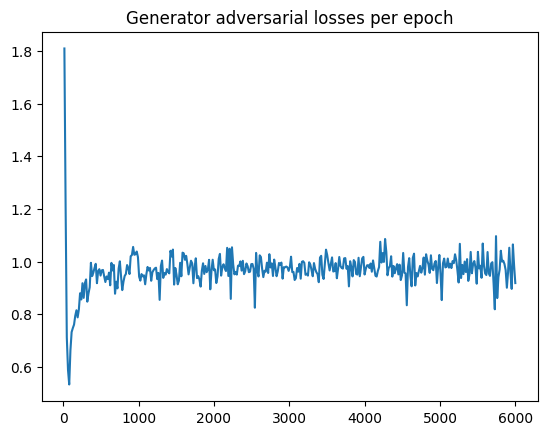

In [ ]:
plt.plot(counter, gen_adv_losses, label="")
plt.title("Generator adversarial losses per epoch")
plt.show()

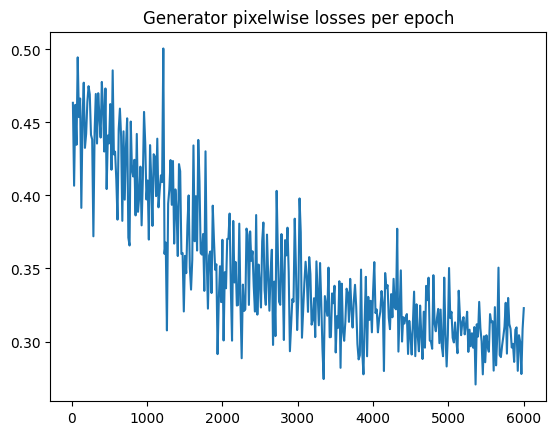

In [ ]:
plt.plot(counter, gen_pixel_losses, label="")
plt.title("Generator pixelwise losses per epoch")
plt.show()

In [ ]:
test_dataloader_validation = DataLoader(
    ImageDataset_Validation(dataset_name, transforms_=transforms_, mode="val", img_size=img_size,mask_size=mask_size),
    batch_size=12,
    shuffle=True,
    num_workers=1,
)

In [ ]:
# g_adv_val = 0
# g_pixel_val = 0
# g_val_loss = 0

# g_psnr_loss = 0
# g_ssim_loss = 0

# d_adv_val = 0
# d_pixel_val = 0
# d_val_loss = 0


# total_time: int = 0
# avg_inference_time: int = 0


# test_tqdm_bar = tqdm(test_dataloader_validation, desc=f'Validation Epoch {epoch} ', total=int(len(test_dataloader)))

# with torch.no_grad():
#     for i, (imgs, masked_imgs, masked_parts) in enumerate(test_tqdm_bar):
#     # Adversarial ground truths
#         valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
#         fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)

#         # Configure input
#         imgs = Variable(imgs.type(Tensor))
#         masked_imgs = Variable(masked_imgs.type(Tensor))
#         masked_parts = Variable(masked_parts.type(Tensor))

#         # measure time

#         if not cuda:
#             starttime = time.time()
#             # Generate a batch of images
#             gen_parts = generator(masked_imgs)
#             time_elapsed_cpu = time.time() - starttime
#             # print(time_elapsed_cpu)

#             total_time += time_elapsed_cpu
#         else:
#             gen_parts = generator(masked_imgs)



#         # Adversarial and pixelwise loss
#         g_adv = adversarial_loss(discriminator(gen_parts), valid)

#         # print(gen_parts.shape, masked_parts.shape)
#         g_pixel = pixelwise_loss(gen_parts, masked_parts)


#         g_adv_val =+ g_adv
#         g_pixel_val += g_pixel
#         g_val_loss += 0.001 * g_adv + 0.999 * g_pixel

#         try:
#             psnr, ssim = calculate_psnr_ssim(gen_parts.detach().numpy(), masked_parts.detach().numpy())
#         except:
#             print("psnr, ssim err: ", gen_parts.shape, masked_parts.shape)

#         g_psnr_loss += psnr
#         g_ssim_loss += ssim


#     g_adv_val /= len(test_dataloader)
#     g_pixel_val /= len(test_dataloader)
#     g_val_loss /= len(test_dataloader)

#     g_psnr_loss /= len(test_dataloader)
#     g_ssim_loss /= len(test_dataloader)

#     avg_inference_time = total_time / len(test_dataloader)

# print(g_adv_val, g_pixel_val, g_val_loss)
# print(g_psnr_loss, g_ssim_loss)
# print("time: ", avg_inference_time)

Validation Epoch 2 :   0%|          | 0/334 [00:00<?, ?it/s]

psnr, ssim err:  torch.Size([4, 1, 64, 64]) torch.Size([4, 1, 64, 64])
tensor(0.0032) tensor(0.2671) tensor(0.2678)
11.894190211857712 0.06145428445390589
time:  0.6796036651748383


In [ ]:
def test_model(test_generator, test_discriminator):
    g_adv_val = 0
    g_pixel_val = 0
    g_val_loss = 0

    g_psnr_loss = 0
    g_ssim_loss = 0

    d_adv_val = 0
    d_pixel_val = 0
    d_val_loss = 0


    total_time: int = 0
    avg_inference_time: int = 0


    test_tqdm_bar = tqdm(test_dataloader_validation, desc=f'Validation Epoch ', total=int(len(test_dataloader)))

    with torch.no_grad():
        for i, (imgs, masked_imgs, masked_parts) in enumerate(test_tqdm_bar):
        # Adversarial ground truths
            valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)

            # Configure input
            imgs = Variable(imgs.type(Tensor))
            masked_imgs = Variable(masked_imgs.type(Tensor))
            masked_parts = Variable(masked_parts.type(Tensor))

            # measure time

            if not cuda:
                starttime = time.time()
                # Generate a batch of images
                gen_parts = test_generator(masked_imgs)
                time_elapsed_cpu = time.time() - starttime
                # print(time_elapsed_cpu)

                total_time += time_elapsed_cpu
            else:
                gen_parts = test_generator(masked_imgs)



            # Adversarial and pixelwise loss
            g_adv = adversarial_loss(test_discriminator(gen_parts), valid)

            # print(gen_parts.shape, masked_parts.shape)
            g_pixel = pixelwise_loss(gen_parts, masked_parts)


            g_adv_val =+ g_adv
            g_pixel_val += g_pixel
            g_val_loss += 0.001 * g_adv + 0.999 * g_pixel

            try:
                psnr, ssim = calculate_psnr_ssim(gen_parts.detach().numpy(), masked_parts.detach().numpy())
            except:
                print("psnr, ssim err: ", gen_parts.shape, masked_parts.shape)

            g_psnr_loss += psnr
            g_ssim_loss += ssim


        g_adv_val /= len(test_dataloader)
        g_pixel_val /= len(test_dataloader)
        g_val_loss /= len(test_dataloader)

        g_psnr_loss /= len(test_dataloader)
        g_ssim_loss /= len(test_dataloader)

        avg_inference_time = total_time / len(test_dataloader)

    print(f"adv loss: {g_adv_val}, pixel loss: {g_pixel_val}, combined loss: {g_val_loss}")
    print(f"psnr loss: {g_psnr_loss} , ssim: {g_ssim_loss}")
    print("time: ", avg_inference_time)

## Modified model

In [ ]:
class Generator_2(nn.Module):
    def __init__(self, channels=3):
        super(Generator_2, self).__init__()

        def downsample(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def upsample(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        # self.model = nn.Sequential(
        #     *downsample(channels, 64, normalize=False),
        #     *downsample(64, 64),
        #     *downsample(64, 128),
        #     *downsample(128, 256),
        #     *downsample(256, 512),
        #     nn.Conv2d(512, 4000, 1),
        #     *upsample(4000, 512),
        #     *upsample(512, 256),
        #     *upsample(256, 128),
        #     *upsample(128, 64),
        #     nn.Conv2d(64, channels, 3, 1, 1),
        #     nn.Tanh()
        # )
        self.model = nn.Sequential(
            *downsample(channels, 16, normalize=False),
            *downsample(16, 32),
            *downsample(32, 64),
            *downsample(64, 128),
            *downsample(128, 128),
            # *downsample(256, 512),
            nn.Conv2d(128, 512, 1),
            *upsample(512, 128),
            # *upsample(512, 256),
            *upsample(128, 64),
            *upsample(64, 32),
            *upsample(32, 16),
            nn.Conv2d(16, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator_2(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator_2, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize in [(64, 2, False), (128, 2, True), (256, 2, True), (512, 1, True)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [ ]:
print(Generator())

Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(512, 4000, kernel_si

In [ ]:
g1 = Generator()
g2 = Generator_2()

In [ ]:
get_param_num(g1)

40401187

In [ ]:
get_param_num(g2)

1723827

In [ ]:
get_param_num(g1)/get_param_num(g2)

23.436915073264313

In [ ]:
print(Generator_2())

Generator_2(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(128, 512, kernel_size

In [ ]:
import torch
from torch import nn

class Generator___111(nn.Module):
    def __init__(self, channels):
        super(Generator___111, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64, eps=0.8, momentum=0.1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128, eps=0.8, momentum=0.1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256, eps=0.8, momentum=0.1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512, eps=0.8, momentum=0.1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(512, 4000, kernel_size=1),
            nn.ConvTranspose2d(4000, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512, eps=0.8, momentum=0.1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256, eps=0.8, momentum=0.1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128, eps=0.8, momentum=0.1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64, eps=0.8, momentum=0.1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1), nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
_generator = Generator___111(channels=channels)

In [ ]:
def get_param_num(model):
    return sum(p.numel() for p in model.parameters())

In [ ]:
sum(p.numel() for p in generator.parameters())

40397985

In [ ]:
sum(p.numel() for p in generator2.parameters())

1723025

In [ ]:
sum(p.numel() for p in _generator.parameters())

40397985

In [ ]:
def test_dimensions_generator(generator):
    pass

In [ ]:
def save_sample_test(batches_done, generator_test):
    samples, masked_samples, i = next(iter(test_dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    i = i[0].item()  # Upper-left coordinate of mask
    # Generate inpainted image
    gen_mask = generator_test(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, i : i + mask_size, i : i + mask_size] = gen_mask

    print('Original images')
    show_image(torchvision.utils.make_grid(masked_samples[1:4],3,1))
    plt.show()
    print("filled images")
    show_image(torchvision.utils.make_grid(filled_samples[1:4],3,1))
    plt.show()

#### Model_original

Using pre-trained Context-Encoder GAN model!
Original images


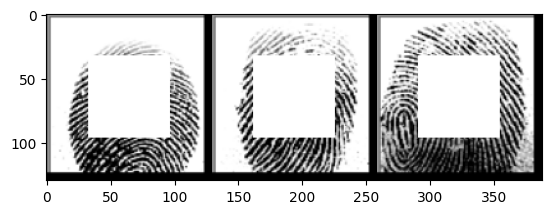

filled images


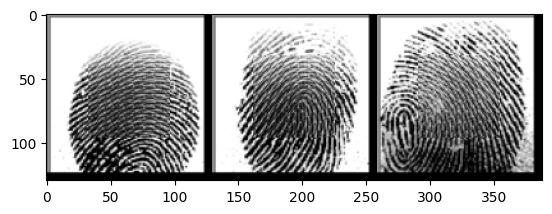

In [ ]:
load_pretrained_models = True
# Initialize generator and discriminator
generator = Generator(channels=channels)
discriminator = Discriminator(channels=channels)

if load_pretrained_models:
    if cuda:
        generator.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/generator_original.pth"))
        discriminator.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/discriminator_original.pth"))
    else:
        generator.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/generator_original.pth", map_location=torch.device('cpu')))
        discriminator.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/discriminator_original.pth", map_location=torch.device('cpu')))
    print("Using pre-trained Context-Encoder GAN model!")

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

if not load_pretrained_models:
    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

save_sample_test(5, generator)

#### Model modified

Using pre-trained Context-Encoder GAN model!
Original images


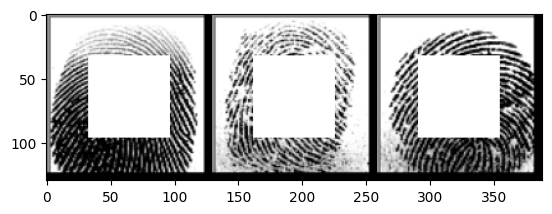

filled images


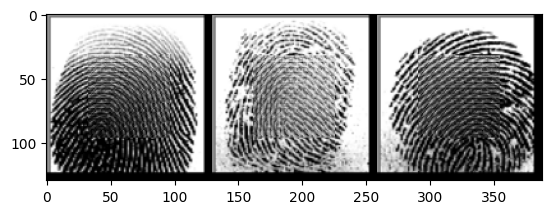

In [ ]:
load_pretrained_models = True
# Initialize generator2 and discriminator
generator2 = Generator_2(channels=channels)
discriminator2 = Discriminator(channels=channels)

if load_pretrained_models:
    if cuda:
        generator2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/generator_modified.pth"))
        discriminator2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/discriminator_modified.pth"))
    else:
        generator2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/generator_modified.pth", map_location=torch.device('cpu')))
        discriminator2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/discriminator_modified.pth", map_location=torch.device('cpu')))
    print("Using pre-trained Context-Encoder GAN model!")

if cuda:
    generator2.cuda()
    discriminator2.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

if not load_pretrained_models:
    # Initialize weights
    generator2.apply(weights_init_normal)
    discriminator2.apply(weights_init_normal)

# Optimizers
optimizer_G2 = torch.optim.Adam(generator2.parameters(), lr=lr, betas=(b1, b2))
optimizer_D2 = torch.optim.Adam(discriminator2.parameters(), lr=lr, betas=(b1, b2))

save_sample_test(5, generator2)

In [ ]:
get_param_num(generator)/get_param_num(generator2)

23.44596567084053

In [ ]:
n_epoch = 100

Original with vgg

In [ ]:
res_1 = train_model(generator, discriminator, optimizer_G, optimizer_D, n_epoch=n_epoch, tag="original")

Training Epoch 0 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 3 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 4 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 5 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 6 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 7 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 8 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 9 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 10 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 11 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 12 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 13 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 14 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 15 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 16 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 17 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 18 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 19 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 20 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 21 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 22 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 23 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 24 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 25 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 26 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 27 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 28 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 29 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 30 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 31 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 32 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 33 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 34 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 35 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 36 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 37 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 38 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 39 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 40 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 41 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 42 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 43 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 44 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 45 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 46 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 47 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 48 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 49 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 50 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 51 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 52 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 53 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 54 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 55 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 56 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 57 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 58 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 59 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 60 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 61 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 62 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 63 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 64 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 65 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 66 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 67 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 68 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 69 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 70 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 71 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 72 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 73 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 74 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 75 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 76 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 77 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 78 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 79 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 80 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 81 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 82 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 83 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 84 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 85 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 86 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 87 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 88 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 89 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 90 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 91 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 92 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 93 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 94 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 95 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 96 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 97 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 98 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 99 :   0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
res_1 = train_model(generator, discriminator, optimizer_G, optimizer_D, n_epoch=1, tag="original_test")

Training Epoch 0 :   0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
test_model(generator, discriminator)

Validation Epoch :   0%|          | 0/334 [00:00<?, ?it/s]

psnr, ssim err:  torch.Size([4, 1, 64, 64]) torch.Size([4, 1, 64, 64])
adv loss: 0.002936392556875944, pixel loss: 0.23361249268054962, combined loss: 0.2343606799840927
psnr loss: 16.61394399501391 , ssim: 0.28248531300298696
time:  1.1417579251135181


Modified with vgg

In [ ]:
res_2 = train_model(generator2, discriminator2, optimizer_G2, optimizer_D2, n_epoch, tag="modified")

Training Epoch 0 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 3 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 4 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 5 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 6 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 7 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 8 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 9 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 10 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 11 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 12 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 13 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 14 :   0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
res_2 = train_model(generator2, discriminator2, optimizer_G2, optimizer_D2, n_epoch=1, tag="modified_test")

Training Epoch 0 :   0%|          | 0/125 [00:00<?, ?it/s]

Original images


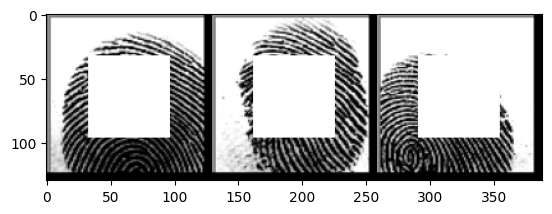

filled images


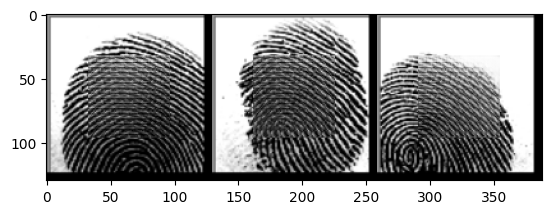

In [ ]:
save_sample_test(7, generator2)

In [ ]:
test_model(generator2, discriminator2)

Validation Epoch :   0%|          | 0/334 [00:00<?, ?it/s]

psnr, ssim err:  torch.Size([4, 1, 64, 64]) torch.Size([4, 1, 64, 64])
adv loss: 0.003124268027022481, pixel loss: 0.2368147373199463, combined loss: 0.23762071132659912
psnr loss: 16.58642891906933 , ssim: 0.27110315949127617
time:  0.10690469941693152


#### Model original without vgg

Using pre-trained Context-Encoder GAN model!
Original images


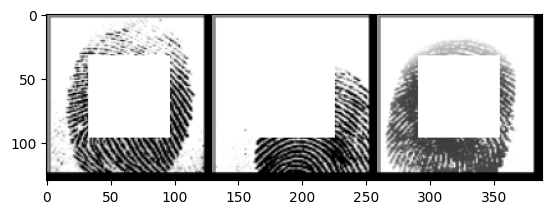

filled images


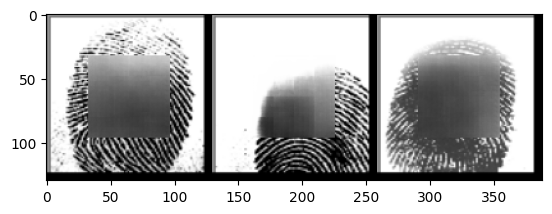

In [ ]:
load_pretrained_models = True
# Initialize generator and discriminator
generator1_2 = Generator(channels=channels)
discriminator1_2 = Discriminator(channels=channels)

if load_pretrained_models:
    if cuda:
        generator1_2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/generator_original_wovgg.pth"))
        discriminator1_2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/discriminator_original_wovgg.pth"))
    else:
        generator1_2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/generator_original_wovgg.pth", map_location=torch.device('cpu')))
        discriminator1_2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/discriminator_original_wovgg.pth", map_location=torch.device('cpu')))
        # generator1_2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/generator_5.pth", map_location=torch.device('cpu')).state_dict())
        # discriminator1_2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/discriminator_5.pth", map_location=torch.device('cpu')).state_dict())
    print("Using pre-trained Context-Encoder GAN model!")

if cuda:
    generator1_2.cuda()
    discriminator1_2.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

if not load_pretrained_models:
    # Initialize weights
    generator1_2.apply(weights_init_normal)
    discriminator1_2.apply(weights_init_normal)

# Optimizers
optimizer_G1_2 = torch.optim.Adam(generator1_2.parameters(), lr=lr, betas=(b1, b2))
optimizer_D1_2 = torch.optim.Adam(discriminator1_2.parameters(), lr=lr, betas=(b1, b2))

save_sample_test(5, generator1_2)

In [ ]:
n_epoch = 100
res_1_2 = train_model(generator1_2, discriminator1_2, optimizer_G1_2, optimizer_D1_2, n_epoch=n_epoch, tag="original_wovgg", perc_loss=False)

Training Epoch 0 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 3 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 4 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 5 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 6 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 7 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 8 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 9 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 10 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 11 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 12 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 13 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 14 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 15 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 16 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 17 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 18 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 19 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 20 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 21 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 22 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 23 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 24 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 25 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 26 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 27 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 28 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 29 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 30 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 31 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 32 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 33 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 34 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 35 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 36 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 37 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 38 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 39 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 40 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 41 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 42 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 43 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 44 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 45 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 46 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 47 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 48 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 49 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 50 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 51 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 52 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 53 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 54 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 55 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 56 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 57 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 58 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 59 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 60 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 61 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 62 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 63 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 64 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 65 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 66 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 67 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 68 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 69 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 70 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 71 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 72 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 73 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 74 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 75 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 76 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 77 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 78 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 79 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 80 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 81 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 82 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 83 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 84 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 85 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 86 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 87 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 88 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 89 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 90 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 91 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 92 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 93 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 94 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 95 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 96 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 97 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 98 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 99 :   0%|          | 0/125 [00:00<?, ?it/s]

Model modified without vgg

Using pre-trained Context-Encoder GAN model!
Original images


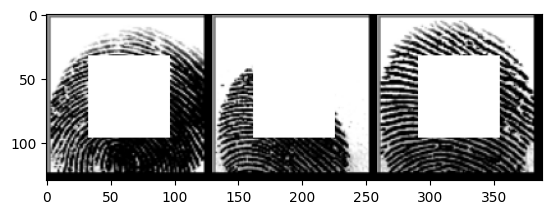

filled images


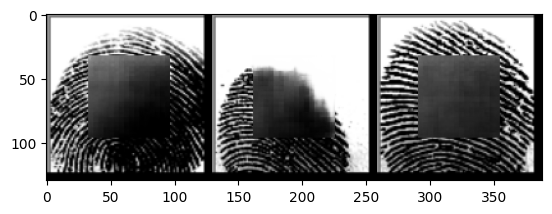

In [ ]:
load_pretrained_models = True
# Initialize generator and discriminator
generator2_2 = Generator_2(channels=channels)
discriminator2_2 = Discriminator_2(channels=channels)

if load_pretrained_models:
    if cuda:
        generator2_2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/generator_modified_wovgg.pth"))
        discriminator2_2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/discriminator_modified_wovgg.pth"))
    else:
        generator2_2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/generator_modified_wovgg.pth", map_location=torch.device('cpu')))
        discriminator2_2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/for_testing/discriminator_modified_wovgg.pth", map_location=torch.device('cpu')))
        # generator2_2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/generator_5.pth", map_location=torch.device('cpu')).state_dict())
        # discriminator1_2.load_state_dict(torch.load("drive/MyDrive/maga/fingerprints/discriminator_5.pth", map_location=torch.device('cpu')).state_dict())
    print("Using pre-trained Context-Encoder GAN model!")

if cuda:
    generator2_2.cuda()
    discriminator2_2.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

if not load_pretrained_models:
    # Initialize weights
    generator2_2.apply(weights_init_normal)
    discriminator2_2.apply(weights_init_normal)

# Optimizers
optimizer_G2_2 = torch.optim.Adam(generator2_2.parameters(), lr=lr, betas=(b1, b2))
optimizer_D2_2 = torch.optim.Adam(discriminator2_2.parameters(), lr=lr, betas=(b1, b2))

save_sample_test(5, generator2_2)

In [ ]:
n_epoch = 100
res_2_2 = train_model(generator2_2, discriminator2_2, optimizer_G2_2, optimizer_D2_2, n_epoch=n_epoch, tag="modified_wovgg", perc_loss=False)

Training Epoch 0 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 3 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 4 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 5 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 6 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 7 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 8 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 9 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 10 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 11 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 12 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 13 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 14 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 15 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 16 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 17 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 18 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 19 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 20 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 21 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 22 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 23 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 24 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 25 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 26 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 27 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 28 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 29 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 30 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 31 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 32 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 33 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 34 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 35 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 36 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 37 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 38 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 39 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 40 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 41 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 42 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 43 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 44 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 45 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 46 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 47 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 48 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 49 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 50 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 51 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 52 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 53 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 54 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 55 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 56 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 57 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 58 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 59 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 60 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 61 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 62 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 63 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 64 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 65 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 66 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 67 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 68 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 69 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 70 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 71 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 72 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 73 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 74 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 75 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 76 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 77 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 78 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 79 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 80 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 81 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 82 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 83 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 84 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 85 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 86 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 87 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 88 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 89 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 90 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 91 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 92 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 93 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 94 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 95 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 96 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 97 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 98 :   0%|          | 0/125 [00:00<?, ?it/s]

Training Epoch 99 :   0%|          | 0/125 [00:00<?, ?it/s]